# Royal University of Phnom Penh
# Faculty of Engineering

# Assignment : News Classification based on Their Headlines

### Professors: Chanpiseth Chap

### Group 3: 
- Muny Roth
- Veong Chamroeun
- Chhoun Seangly
- Seng Vutthea
- Mon David

# 1. Input data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## 1.1 Reading the dataset

In [2]:
# Reading the dataset
src_file = 'dataset.csv'
dataframe = pd.read_csv(src_file, encoding="utf8", quotechar="\"", engine='python', usecols=["TITLE", "CATEGORY"])
dataframe.head(5)

,TITLE,CATEGORY
0,Loved ones hoping for justice in the 2014 Ohio...,COLD CASE SPOTLIGHT
1,"Judges' safety is 'essential' to court system,...",U.S. NEWS
2,Suspect in Idaho killings had made 'creepy' co...,U.S. NEWS
3,Airline worker killed in accident at Alabama a...,U.S. NEWS
4,Storm dumps heavy rain and snow across California,U.S. NEWS


In [3]:
dataframe.shape

(11936, 2)

## 1.2 Exploratory data analysis

### 1.2.1 Dataframe information

In [4]:
dataframe.describe()

,TITLE,CATEGORY
count,11936,11795
unique,11823,215
top,Graphic: Track grocery price trends,U.S. NEWS
freq,6,2692


### 1.2.2 Dataframe visualization

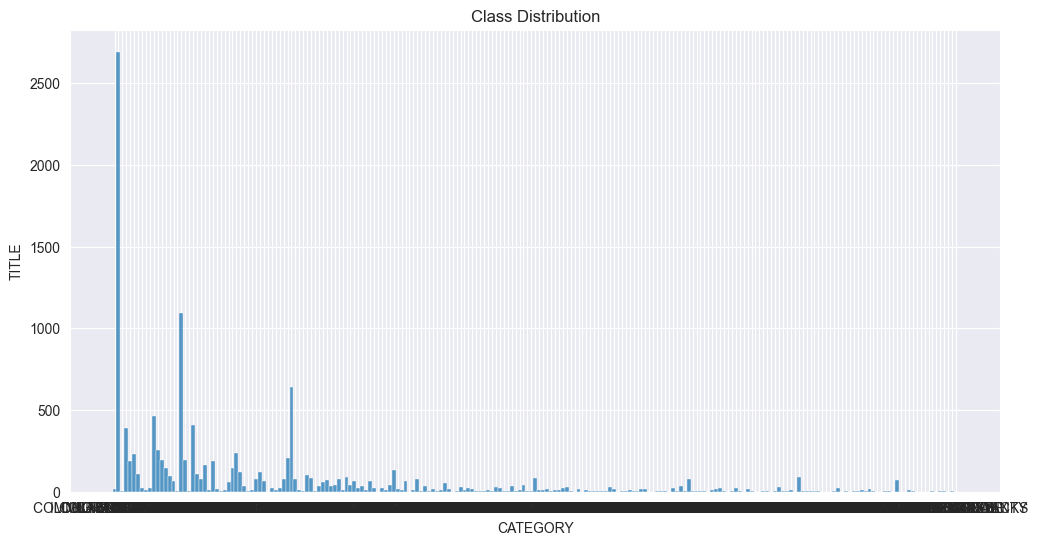

In [5]:
plt.figure(figsize=(12, 6))
sns.histplot(dataframe['CATEGORY'])
plt.title("Class Distribution")
plt.ylabel('TITLE')
plt.show()

# 2. Data Preprocessing

## 2.1 Data Selection

We will filter data for category that have titles over 300.

In [6]:
# Filter the dataset minimum having 300 rows per category
dataframe = dataframe.groupby("CATEGORY").filter(lambda x: len(x) >= 300)

## 2.2 Data Cleaning

And then we will check for missing data and duplicate rows and then remove them.

In [7]:
# Checking for missing data
if any(dataframe.isnull().any()):
    print('Missing Data\n')
    print(dataframe.isnull().sum())
else:
    print('No missing data')

No missing data


In [8]:
# Checking for duplicate rows
if any(dataframe.duplicated()):
    print('Duplicate rows found')
    print('Number of duplicate rows= ', dataframe[dataframe.duplicated()].shape[0])
    dataframe.drop_duplicates(inplace=True, keep='first')
    dataframe.reset_index(inplace=True, drop=True)
    print('Dropping duplicates\n')
    print(dataframe.shape)
else:
    print('No duplicate data')

Duplicate rows found
Number of duplicate rows=  35
Dropping duplicates

(5653, 2)


We now have a clean dataset with no missing data and no duplicate rows.

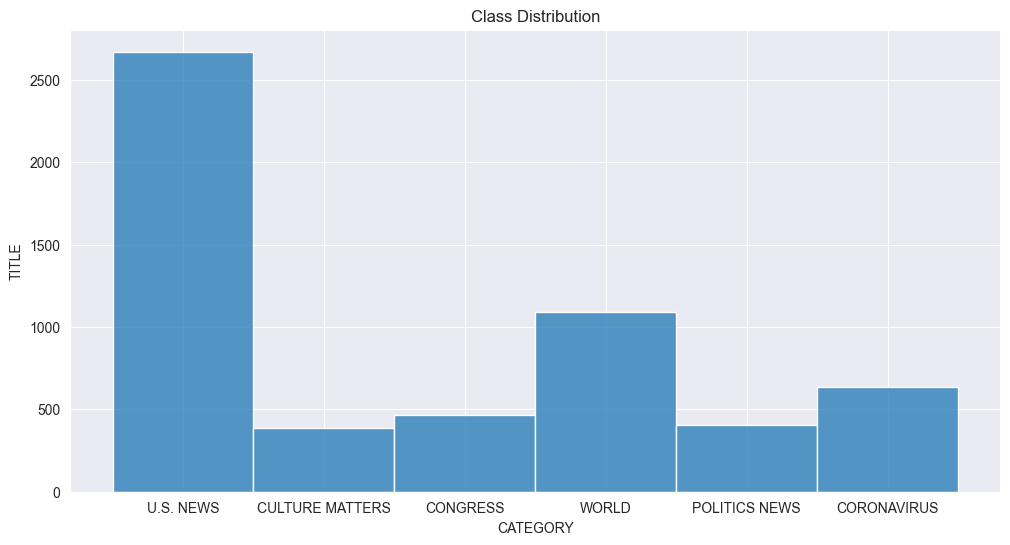

In [9]:
# Explore class distribution
plt.figure(figsize=(12, 6))
sns.histplot(dataframe['CATEGORY'])
plt.title("Class Distribution")
plt.ylabel('TITLE')
plt.show()

## 2.3 Data Transformation

In this step we'll remove outliers and transform the data using TF-IDF.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from sklearn import set_config

# Set sklearn config to output Pandas DataFrame
set_config(transform_output="pandas")
wnl = WordNetLemmatizer()


# Function for cleaning and tokenize the headline
def tokenize(doc):
    document = doc.lower()  # convert the content of the headline to lowercase
    document = re.sub(r'\d+', '', document)  # remove all the digits inside the content (using regular expressions)
    document = re.sub(r'[^a-zA-Z\s]', '',
                      document)  # remove all the special characters inside the content (using regular expressions)
    document = document.translate(str.maketrans('', '', string.punctuation))  # remove the punctuations (, . ! # ...)
    document = document.strip()  # remove the spaces at the start and end of the headline
    return [wnl.lemmatize(token) for token in word_tokenize(document) if token not in stopwords.words('english')]
    # tokenize the headlines
    # and then filter only the words that are not in the english stopwords (words that are commonly used and give no benefits to the classifier)
    # and finally templatize all the tokens


# Preprocessing Pipeline
preprocessor = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize, token_pattern=None)),
])

# Transforming the dataset using TF-IDF
tfidf_dataset = preprocessor.fit_transform(dataframe["TITLE"].values)

# 3. Model Training

## 3.1 Label encoder

In [11]:
from sklearn.preprocessing import LabelEncoder

# Encode the target labels
le = LabelEncoder()
class_label = le.fit_transform(dataframe["CATEGORY"])

## 3.2 Train-Test Split

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_dataset.toarray(),  # Convert TF-IDF sparse matrix to dense array
    class_label,  # Target labels
    test_size=0.3  # the size of the testing dataset (in percentage between 0 and 1)
)

print(X_train.shape)
print(X_test.shape)

(3957, 9149)
(1696, 9149)


## 3.3 Model Training

### 3.3.1 Decision Tree Classifier

In [13]:
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree classifier
dt_model = DecisionTreeClassifier(criterion="gini", splitter="best", random_state=42)

# Train the classifier on the training dataset
dt_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_dt = dt_model.predict(X_test)

### 3.3.2 Naive Bayes Classifier

In [14]:
from sklearn.naive_bayes import MultinomialNB

# Create a Multinomial Naive Bayes classifier
nb_model = MultinomialNB()

# Train the classifier on the training dataset
nb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_nb = nb_model.predict(X_test)

### 3.3.3 Neural Network Classifier

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Build the neural network model
nn_model = Sequential()
# Input layer
nn_model.add(Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
# Hidden layers
nn_model.add(Dense(32, activation='relu'))
# Output layer
num_classes = len(np.unique(class_label))
nn_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
nn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
nn_model_trained = nn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Make predictions on the test data
y_pred_nn = np.argmax(nn_model.predict(X_test), axis=-1)

/Users/munyroth/Desktop/Python/Assignment/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch 1/20
112/112 [==============================] - 0s 2ms/step - loss: 1.5692 - accuracy: 0.4591 - val_loss: 1.3364 - val_accuracy: 0.4747
Epoch 2/20
112/112 [==============================] - 0s 2ms/step - loss: 1.1141 - accuracy: 0.5515 - val_loss: 1.0564 - val_accuracy: 0.6136
Epoch 3/20
112/112 [==============================] - 0s 1ms/step - loss: 0.7311 - accuracy: 0.7762 - val_loss: 0.8732 - val_accuracy: 0.7172
Epoch 4/20
112/112 [==============================] - 0s 1ms/step - loss: 0.4459 - accuracy: 0.8565 - val_loss: 0.7517 - val_accuracy: 0.7399
Epoch 5/20
112/112 [==============================] - 0s 1ms/step - loss: 0.2648 - accuracy: 0.9413 - val_loss: 0.6966 - val_accuracy: 0.7727
Epoch 6/20
112/112 [==============================] - 0s 1ms/step - loss: 0.1524 - accuracy: 0.9843 - val_loss: 0.6817 - val_accuracy: 0.7677
Epoch 7/20
112/112 [==============================] - 0s 1ms/step - loss: 0.0870 - accuracy: 0.9921 - val_loss: 0.6769 - val_accuracy: 0.7652
Epoch 

# 4. Model Evaluation

In [16]:
from sklearn.metrics import precision_recall_fscore_support


def evaluate_model(model, y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=1)

    print(f"Accuracy score of {model}: {accuracy}")
    print(f"Precision score of {model}: {precision}")
    print(f"Recall score of {model}: {recall}")
    print(f"F1 score of {model}: {f1}")

## 4.1 Decision Tree

In [17]:
evaluate_model("Decision Tree", y_pred_dt, y_test)

Accuracy score of Decision Tree: 0.7270047169811321
Precision score of Decision Tree: 0.718227831684369
Recall score of Decision Tree: 0.7270047169811321
F1 score of Decision Tree: 0.7203447793694143


In [18]:
classification_report(y_test, y_pred_nn, zero_division=1)

'              precision    recall  f1-score   support\n\n           0       0.87      0.58      0.69       147\n           1       0.83      0.76      0.80       176\n           2       0.71      0.50      0.59       117\n           3       0.44      0.54      0.49       120\n           4       0.82      0.89      0.85       816\n           5       0.78      0.79      0.79       320\n\n    accuracy                           0.78      1696\n   macro avg       0.74      0.68      0.70      1696\nweighted avg       0.78      0.78      0.78      1696\n'

## 4.2 Naive Bayes

In [19]:
evaluate_model("Naive Bayes", y_pred_nb, y_test)

Accuracy score of Naive Bayes: 0.6326650943396226
Precision score of Naive Bayes: 0.7434245754911473
Recall score of Naive Bayes: 0.6326650943396226
F1 score of Naive Bayes: 0.5631785161509894


In [20]:
classification_report(y_test, y_pred_nn, zero_division=1)

'              precision    recall  f1-score   support\n\n           0       0.87      0.58      0.69       147\n           1       0.83      0.76      0.80       176\n           2       0.71      0.50      0.59       117\n           3       0.44      0.54      0.49       120\n           4       0.82      0.89      0.85       816\n           5       0.78      0.79      0.79       320\n\n    accuracy                           0.78      1696\n   macro avg       0.74      0.68      0.70      1696\nweighted avg       0.78      0.78      0.78      1696\n'

## 4.3 Neural Network

In [21]:
evaluate_model("Neural Network", y_pred_nn, y_test)

Accuracy score of Neural Network: 0.7794811320754716
Precision score of Neural Network: 0.784768748770503
Recall score of Neural Network: 0.7794811320754716
F1 score of Neural Network: 0.7772087331550261


In [22]:
classification_report(y_test, y_pred_nn, zero_division=1)

'              precision    recall  f1-score   support\n\n           0       0.87      0.58      0.69       147\n           1       0.83      0.76      0.80       176\n           2       0.71      0.50      0.59       117\n           3       0.44      0.54      0.49       120\n           4       0.82      0.89      0.85       816\n           5       0.78      0.79      0.79       320\n\n    accuracy                           0.78      1696\n   macro avg       0.74      0.68      0.70      1696\nweighted avg       0.78      0.78      0.78      1696\n'

# 5. Model Visualization

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

## 4.1 Decision Tree

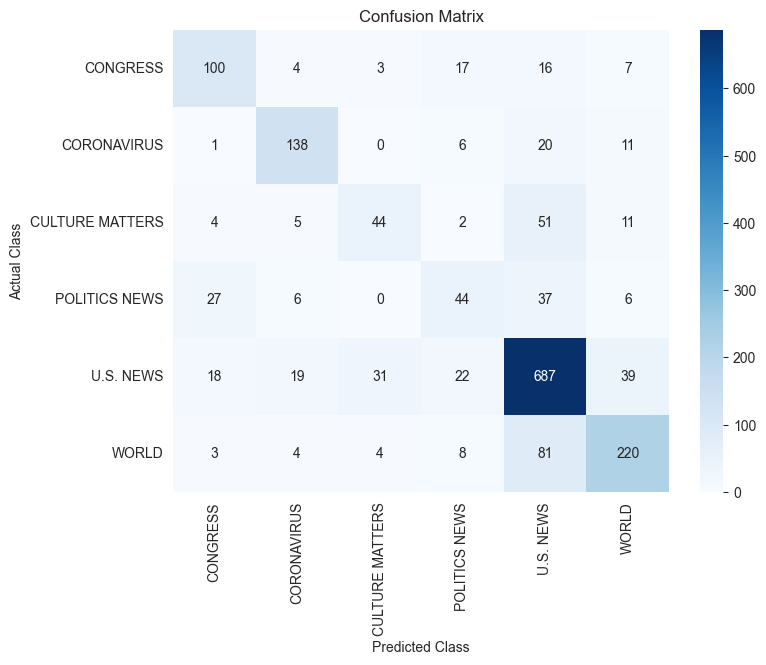

In [24]:
plot_confusion_matrix(y_test, y_pred_dt, classes=le.classes_)

## 4.2 Naive Bayes

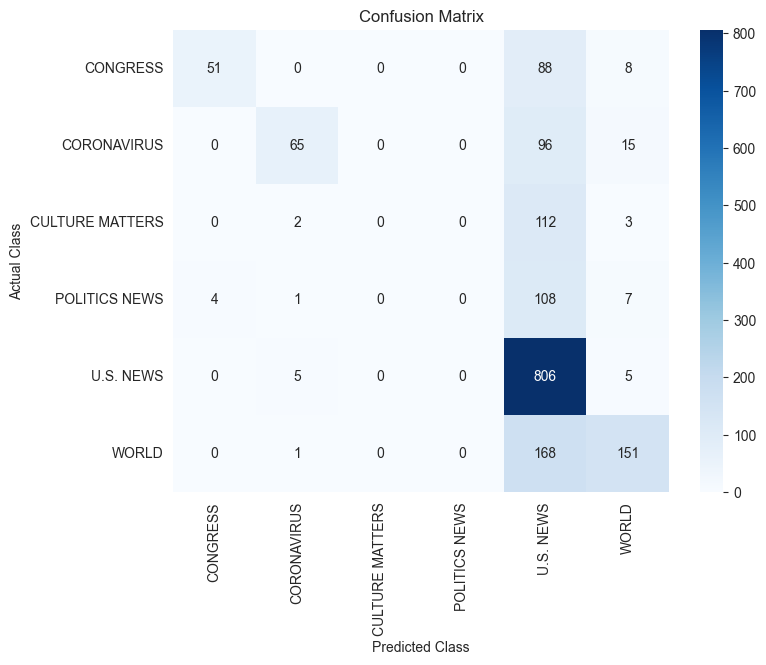

In [25]:
plot_confusion_matrix(y_test, y_pred_nb, classes=le.classes_)

## 4.3 Neural Network

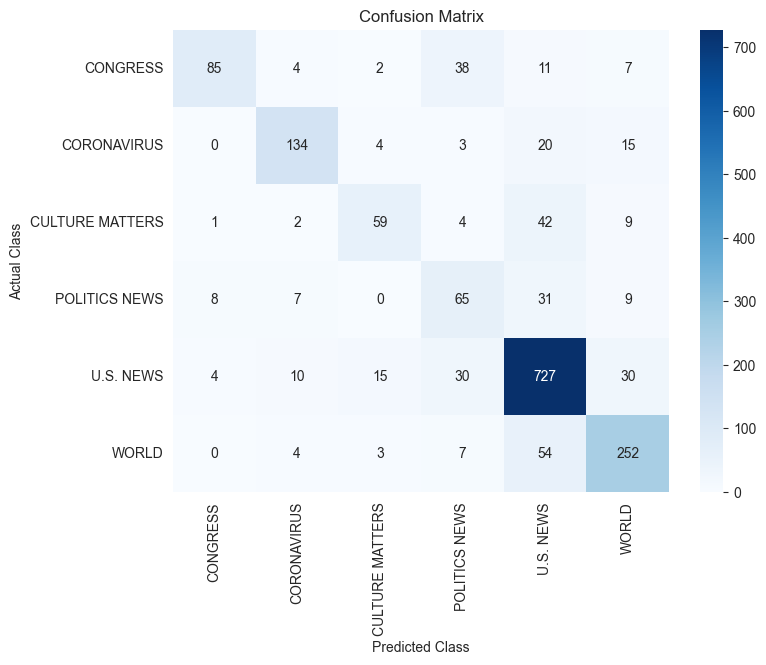

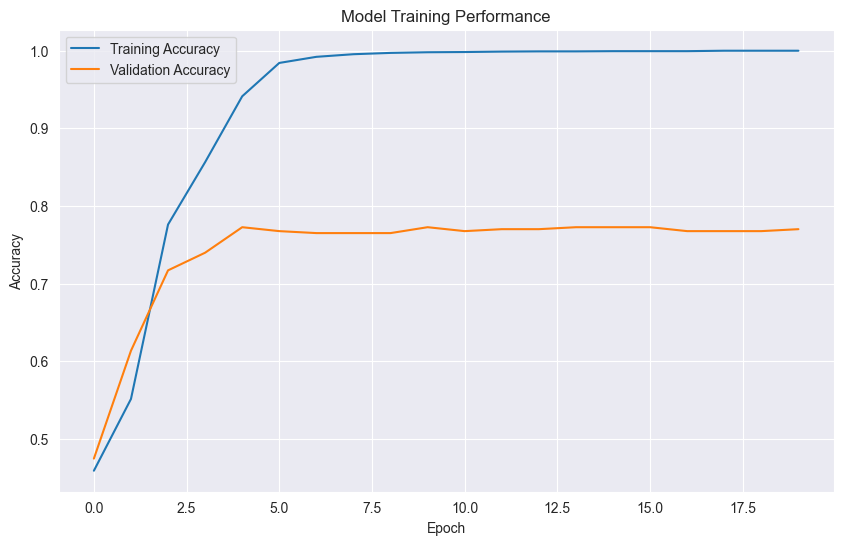

In [26]:
def plot_learning_curve(history):
    plt.figure(figsize=(10, 6))

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Training Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_confusion_matrix(y_test, y_pred_nn, classes=le.classes_)
plot_learning_curve(nn_model_trained)